规则：  
猜词，字母猜对，位置不对为黄色，位置对为绿色，两者皆不对为灰色。  
困难模式下的要求：对于猜对的字母（绿色和灰色），下一步必须使用  


要求：
* 报告结果的数量每天都在变化。开发一个模型来解释这种变化，并使用您的模型为2023年3月1日报告的结果数量创建一个预测区间。单词的任何属性是否会影响在硬模式下播放的报告分数百分比？如果是，怎么办？如果没有，为什么不呢？

* 对于给定的未来解决方案单词，在未来的日期，开发一个模型，使您能够预测报告结果的分布。换句话说，预测未来日期（1，2，3，4，5，6，X）的相关百分比。你的模型和预测有哪些不确定性？举一个具体的例子，说明你对2023年3月1日EERIE一词的预测。你对模型的预测有多自信？  
* 开发并总结一个模型，根据难度对解决方案单词进行分类。识别与每个分类相关的给定单词的属性。使用你的模型，EERIE这个词有多难？讨论分类模型的准确性。  
* 列出并描述此数据集的一些其他有趣的功能。  

最后，在给《纽约时报》拼图编辑的一到两页信中总结你的结果。

结果每天都在变化的原因：
1. 是否工作日，人们尝试的意愿有多大  
    新增一列为是否为工作日，或者判断为周几  
    
2. 昨天或者前几天的难度对于游玩心态的影响  
    虽然尝试次数这里使用的是百分比，但是总分数与困难模式下的分数为具体的值，尝试的人的数量不同则总分不同。
3. 单词的难度，包括长度，重复字母的数量，词性等
    长度是固定的不需要考虑   
    存在的问题：对于同一个字母的多次使用，他是怎么进行显示的，比如我输入了全是A的情况，他显示的是除了对的位置是绿色，其他全是黄色还是其他的什么情况？  
4. 单词是否为常见词，或者和常见词的相似度  
    在此基础上就需要常见词库，以及单词相似度度量  



需要预测的东西：
不同尝试次数的百分比分布，分数区间，困难的分数


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
# 注意：这是DS数模（公众号、面包多、知乎）团队制作的进阶思路，在公众号：DS数模，输入：美赛，或加群：557421704，获取
# 正版资源。有疑问，请务必购买正版，加入答疑群，可能现在的进阶版本并不完善，后期有问题也会更新。

In [5]:
df = pd.read_excel('Problem_C_Data_Wordle.xlsx', header=1)
df=df[df.columns[1:]]
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3


预处理：
1. 百分比之和可能不等于1，所以对其进行归一化  
2. 按照'Contest Number'对整个表进行升序排列  
3. 判断当前日期是否为周末，为周几   
4. 统计单词中字母个数，重复出现的字母算一次  
5. 对单词进行词性标注  

In [160]:
df = pd.read_excel('Problem_C_Data_Wordle.xlsx', header=1)
df=df[df.columns[1:]]
#  对尝试次数进行归一化，使其结果和等于100
df = df.sort_values(by='Contest number', ignore_index=True)
percent = df[df.columns[5:]].sum(axis=1)
for column in df.columns[5:]:
    df[column]=df[column]/percent*100
# 判断当前日期为周几，周一为0，依次增加  
df['week']=df['Date'].apply(lambda x:x.weekday())
df['is_weekend'] = df['week'].apply(lambda x:x>4)
# 统计单词中字母的个数  
df['word_len'] = df['Word'].apply(lambda x:len(set(x)))
# 对单词进行词性标注
df['tag'] = df['Word'].apply(lambda x:nltk.pos_tag(nltk.word_tokenize(x))[0][1])
df.head()    
# 注意：这是DS数模（公众号、面包多、知乎）团队制作的进阶思路，在公众号：DS数模，输入：美赛，或加群：557421704，获取
# 正版资源。有疑问，请务必购买正版，加入答疑群，可能现在的进阶版本并不完善，后期有问题也会更新。

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),week,is_weekend,word_len,tag
0,2022-01-07,202,slump,80630,1362,1.000000,3.000000,23.000000,39.000000,24.000000,9.000000,1.000000,4,False,5,NN
1,2022-01-08,203,crank,101503,1763,1.000000,5.000000,23.000000,31.000000,24.000000,14.000000,2.000000,5,True,5,NN
2,2022-01-09,204,gorge,91477,1913,1.000000,3.000000,13.000000,27.000000,30.000000,22.000000,4.000000,6,True,4,NN
3,2022-01-10,205,query,107134,2242,1.000000,4.000000,16.000000,30.000000,30.000000,17.000000,2.000000,0,False,5,NN
4,2022-01-11,206,drink,153880,3017,0.990099,8.910891,34.653465,33.663366,15.841584,4.950495,0.990099,1,False,5,NN


# 第一题  
第一小问：  
Q：报告结果的数量每天都在变化。开发一个模型来解释这种变化，并使用您的模型为2023年3月1日报告的结果数量创建一个预测区间。    
首先判断是否与周几有关，如果有则将该参数加入模型中，如果没有则不加入  
使用时间预测模型，或者二次函数训练，使用留一法等交叉验证方法得到关于模型准确率的描述。  
第二小问：  
Q：单词的任何属性是否会影响在硬模式下播放的报告分数百分比？如果是，怎么办？如果没有，为什么不呢？  
A： 任何属性可以包括：唯一字母的数量，单词的词性，常见度，字母的词频  
   差异度分析，相关性分析  

分析整体的星期几对得分均值的影响

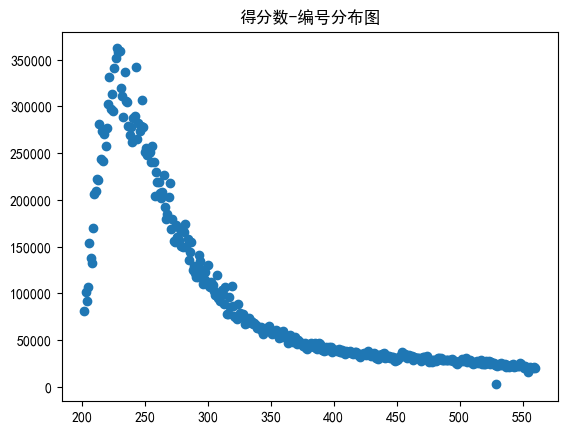

In [81]:
plt.scatter(df['Contest number'], df['Number of  reported results'])
plt.title('得分数-编号分布图')
plt.show()
# 注意：这是DS数模（公众号、面包多、知乎）团队制作的进阶思路，在公众号：DS数模，输入：美赛，或加群：557421704，获取
# 正版资源。有疑问，请务必购买正版，加入答疑群，可能现在的进阶版本并不完善，后期有问题也会更新。

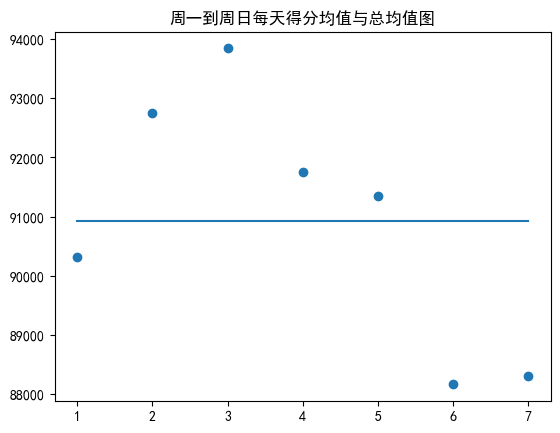

In [90]:
weeks = []
for week in range(7):
    df1 = df[df['week']==week]
    weeks.append(df1['Number of  reported results'].mean())
plt.scatter([i+1 for i in range(7)], weeks)
plt.plot([i+1 for i in range(7)], [df['Number of  reported results'].mean() for i in range(7)])
plt.title('周一到周日每天得分均值与总均值图')
# 其中直线为总均值图，散点图为每天的
plt.show()

In [87]:
# 整体得分与星期几之间的相关性
np.corrcoef(df['week'], df['Number of  reported results'])


array([[ 1.        , -0.01421786],
       [-0.01421786,  1.        ]])

可以看到，在整个时间段中，星期几与得分情况的相关性不大，甚至可以说不相关。

取得分总体趋于稳定后的区域，判断星期几对得分的影响

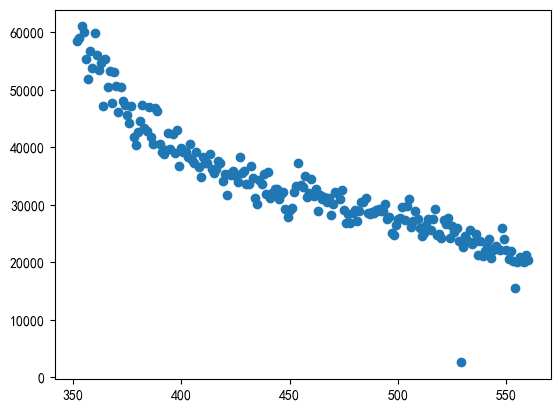

In [94]:
a = 150 # 暂定为150，可以自己设置对应的趋于平稳的阈值
plt.scatter(df['Contest number'][a:], df['Number of  reported results'][a:])

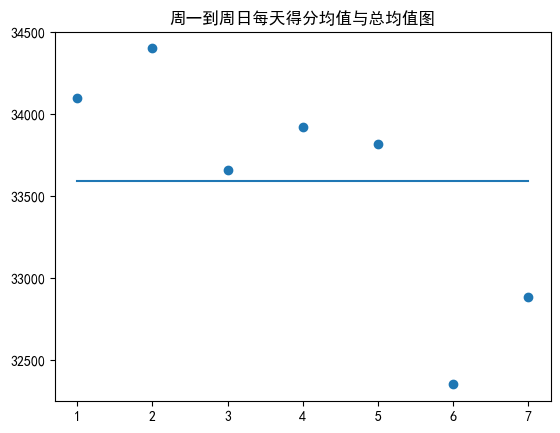

In [96]:
df1 = df.iloc[a:]
weeks = []
for week in range(7):
    df2 = df1[df1['week']==week]
    weeks.append(df2['Number of  reported results'].mean())
plt.scatter([i+1 for i in range(7)], weeks)
plt.plot([i+1 for i in range(7)], [df1['Number of  reported results'].mean() for i in range(7)])
plt.title('周一到周日每天得分均值与总均值图')
# 其中直线为总均值图，散点图为每天的
plt.show()

In [97]:
np.corrcoef(df['Contest number'][a:], df['Number of  reported results'][a:])

array([[ 1.        , -0.92371301],
       [-0.92371301,  1.        ]])

从图和相关系数可以看出，星期几与得分存在较大的负相关关系，且周末（周六周日）的得分明显小于工作日的得分情况。

所以可以从两种情况进行模型的建立
1. 从整体出发，建立日期或者单词编号与得分的模型   
2. 从趋于稳定的部分出发，建立日期，周几与得分的模型  

In [194]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

In [144]:
X = df[['Contest number']].values
y = df['Number of  reported results'].values

使用随机森林

交叉验证模型准确率

In [161]:
kfold = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kfold.split(X, y):
    train_X = X[train_index, :]
    train_y = y[train_index]
    test_X = X[test_index, :]
    test_y = y[test_index]
    rfr = RandomForestRegressor()
    rfr.fit(train_X, train_y)
    pre_y = rfr.predict(test_X)
    print(mean_absolute_error(test_y, pre_y), mean_squared_error(test_y, pre_y))

6702.6455555555585 112348914.45245005
6856.557222222224 143458560.0612279
6266.250833333331 101343282.63094717
7528.303333333334 194806894.7660723
9122.216666666667 229023362.8441722
5647.178333333332 135697952.52833328
4337.371388888888 47514493.72993609
6080.945277777778 97613721.8106028
4343.403888888889 78739939.8483723
6295.156000000003 101485743.10775432


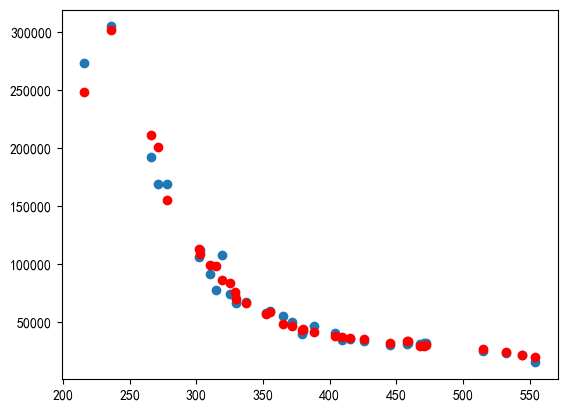

In [162]:
plt.scatter(test_X, test_y)
plt.scatter(test_X, pre_y, c='r')
plt.show()

2227.91356545961 15634688.272733426


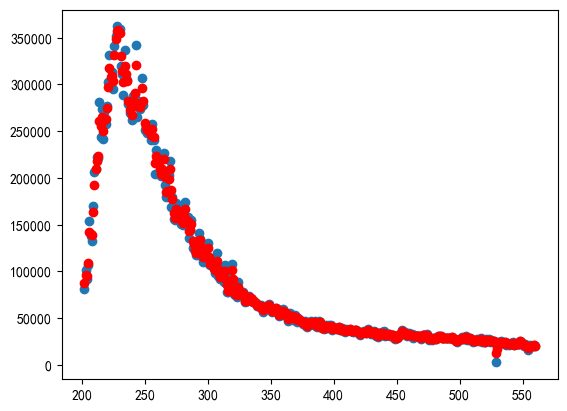

In [163]:
rfr = RandomForestRegressor()
rfr.fit(X,y)
pre_y = rfr.predict(X)
print(mean_absolute_error(y, pre_y),mean_squared_error(y, pre_y))
plt.scatter(X, y)
plt.scatter(X, pre_y, c='r')
plt.show()

In [192]:
# 将预测的日期转为Contest number
day = int(str(datetime(2023, 3,1)-df['Date'][0]).split('days')[0])+202
# 预测得分
rfr.predict([[day]])

array([20488.27])

这里存在问题，随机森林只能预测定义域范围内的，如果超过定义域的话结果就等于边界值了。    


对趋于稳定的区域进行建模

In [199]:
df1 = df.iloc[a:]
X = df1[['Contest number']].values
y = df1['Number of  reported results'].values

kfold = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kfold.split(X, y):
    train_X = X[train_index, :]
    train_y = y[train_index]
    test_X = X[test_index, :]
    test_y = y[test_index]
    svr = SVR(kernel='rbf')
    svr.fit(train_X, train_y)
    pre_y = svr.predict(test_X)
    print(mean_absolute_error(test_y, pre_y), mean_squared_error(test_y, pre_y))

9141.322815360963 135158582.26779914
6064.286276083147 45335501.24389154
6154.880496502352 50875067.294052914
8098.897188581997 124431360.5737025
6603.862764562136 87267646.08112791
9481.239239908471 149807732.22645593
8923.098935163329 141512641.2251412
6534.552151154038 76058498.68222871
5614.86255837207 64081094.12134743
7706.893600154018 111538738.93719411


In [205]:
svr = SVR(kernel='linear')
svr.fit(X, y)
pre_y = svr.predict(X)
# 注意：这是DS数模（公众号、面包多、知乎）团队制作的进阶思路，在公众号：DS数模，输入：美赛，或加群：557421704，获取
# 正版资源。有疑问，请务必购买正版，加入答疑群，可能现在的进阶版本并不完善，后期有问题也会更新。

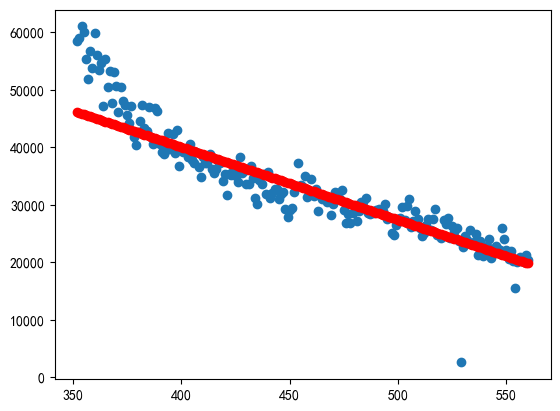

In [206]:
plt.scatter(X, y)
plt.scatter(X, pre_y, c='r')
plt.show()